# Carotte 4.0 : Traitement d'images Hyperspectrales
Ce notebook Jupyter présentera les différentes expérimentations qui ont mené à la détermination de notre Pipeline de traitement d'images hyperspectrales.

In [43]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
import sklearn
%matplotlib inline

# Données
Les deux images que nous possédons pour créer notre pipeline ont été acquises par le capteur AVIRIS.

## Afficher des images hyperspectrales en RGB

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.

Wikipedia donne :
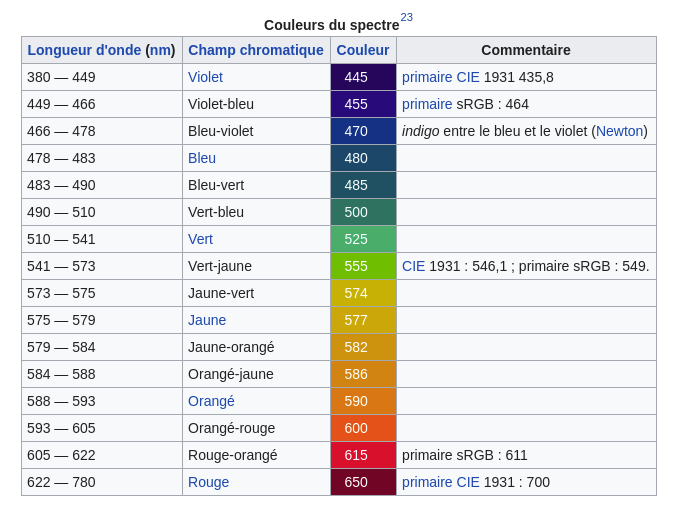

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [44]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
def rgb_bands(arr):
    r = find_index_wavelength(611)
    g = find_index_wavelength(549)
    b = find_index_wavelength(464)
    return [r, g, b]
def pimpImageInRgb(image, rgb_bands):
    img_rgb = image.copy()[:,:,rgb_bands]
    
    rgb_min, rgb_max = np.percentile(img_rgb, (1, 99), axis=(0,1))

    new_image = img_rgb.copy()
    for i in range(rgb_min.size):
        new_image[:,:,i] = (img_rgb[:,:,i] - rgb_min[i]) / (rgb_max[i] - rgb_min[i])
    
    new_image[new_image < 0] = 0
    new_image[new_image > 1] = 1
    return new_image

## Indiana Pines
C'est la première image que nous possédons. Elle à une résolution de 145x145 pixels, ce qui donne une résolution au sol de 20 m/pixel.
L'image de vérité terrain contient 15 classes différentes, avec la classe 0 appartenant à la catégorie "Inconnu".

In [45]:
# import de l'image indiana pines
arr_indiana = np.load("./data/indianapines.npy")
arr_indiana_gt = np.load("./data/indianapines_gt.npy")

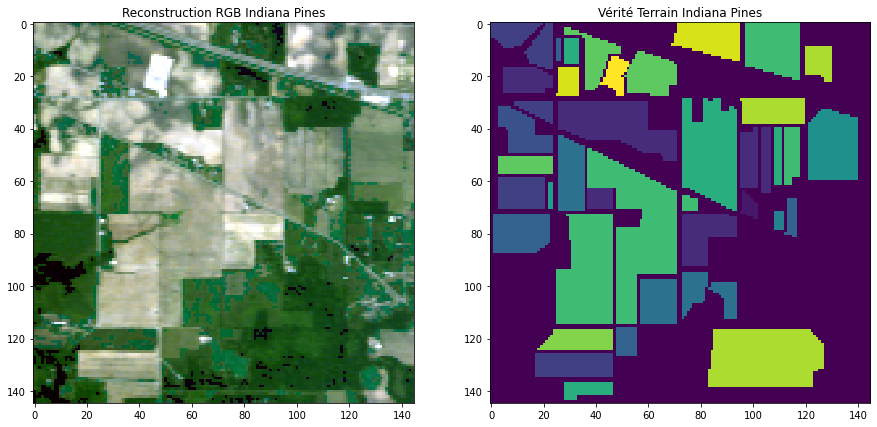

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[1].imshow(arr_indiana_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1].set_title("Vérité Terrain Indiana Pines")
axs[0].imshow(pimpImageInRgb(normalize(arr_indiana), rgb_bands(arr_indiana)), cmap="viridis", aspect="auto", interpolation="none")
axs[0].set_title("Reconstruction RGB Indiana Pines")
plt.show()

In [53]:
indiana_dict = {
    "unknown" : 10776,
    "alfalfa" : 46,
    "corn-notill": 1428,
    "corn-mintill": 830,
    "corn": 237,
    "grass-pasture": 483,
    "grass-trees": 730,
    "grass-pasture-mowed": 28,
    "hay-windrowed": 478,
    "oats": 20,
    "soybean-notill": 972,
    "soybean-mintill": 2455,
    "soybean-clean": 593,
    "wheat": 205,
    "woods": 1265,
    "buildings-grass-trees-drives": 386,
    "stone-steel-towers": 93
}

On remarque le manque d'information pour certaines classes, notamment "oats" et "grass-pasture-mowed". Cela rendra la classification difficile pour ces classes en particulier.

## Salinas
Cette image possède des classes différentes de l'image Indiana Pines. Elle à aussi une résolution supérieure de 512x217 pixels.
Elle devrait ainsi être plus simple à traiter.

In [54]:
# import de la vérité terrain
arr_salinas = np.load("./data/salinas.npy")
arr_salinas_gt = np.load("./data/salinas_gt.npy")

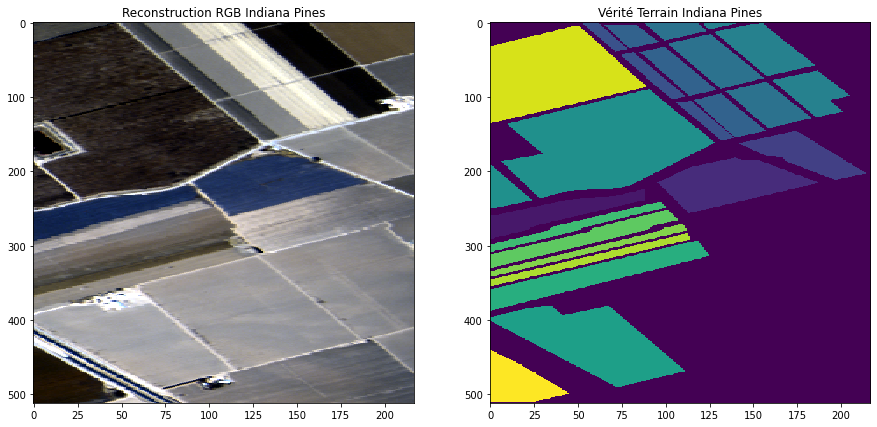

In [55]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[1].imshow(arr_salinas_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1].set_title("Vérité Terrain Indiana Pines")
axs[0].imshow(pimpImageInRgb(normalize(arr_salinas), rgb_bands(arr_salinas)), cmap="viridis", aspect="auto", interpolation="none")
axs[0].set_title("Reconstruction RGB Indiana Pines")
plt.show()

In [58]:
salinas_dict = {
    "unknown" : 56975,
    "brocoli_green_weeds_1" : 2009,
    "brocoli_green_weeds_2" : 3726,
    "fallow" : 1976,
    "fallow_rough_plow" : 1394,
    "fallow_smooth" : 2678,
    "stubble" : 3959,
    "celery" : 3579,
    "grapes_untrained" : 11271,
    "soil_vinyard_develop" : 6203,
    "corn_senesced_green_weeds" : 3278,
    "lettuce_romaine_4wk" : 1068,
    "lettuce_romaine_5wk" : 1927,
    "lettuce_romaine_6wk" : 916,
    "lettuce_romaine_7wk" : 1070,
    "vinyard_untrained" : 7268,
    "vinyard_vertical_trellis" : 1807
}

**Essayer de retirer totalement la classe unknown du dataset de train ?**

# Réduction de dimension
Les images hyperspectrales possédant un nombre très important de bandes pour chaque pixel, elle pourront fortement bénificier d'une réduction, permettant de traiter ces images plus rapidement, et de se focaliser sur les caractéristiques essentielles.

## Analyse en composantes principales
La technique d'analyse en composantes principales (ou PCA) permet d'effectuer une réduction de dimension, en ne gardant que les premières composantes.
Appliquons cette méthode à nos images, et observons la perte de données associée.

In [126]:
from math import ceil
def show_info_pca(arr, varFactor):
    row, col, dim = arr.shape
    # The array is reshaped to be flat
    arr_flat = arr.reshape((-1, dim))
    
    import sklearn.decomposition
    pca_arr = sklearn.decomposition.PCA()
    pca_arr.fit(arr_flat)
    
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Explained variance per PC')
    plt.plot(np.arange(1,dim+1),pca_arr.explained_variance_,'b')
    plt.xlabel('PC number')
    plt.xlim(1,dim+1)
    plt.subplot(122)
    plt.title('Explained variance per PC (in log scale)')
    plt.plot(np.arange(1,dim+1),pca_arr.explained_variance_,'b')
    plt.xlabel('PC number')
    plt.xlim(1,dim+1)
    plt.yscale('log')
    plt.show()
    
    
    
    var_cumsum = pca_arr.explained_variance_ratio_.cumsum()
    
    nbPCs = np.where(var_cumsum > varFactor)[0][0]
    print('%d components are necessary to retain %1.2f%% of the total variance'%((nbPCs+1),100*varFactor))
    
    nb_comp = nbPCs
    
    arr_projected = pca_arr.transform(arr_flat)
    arr_projected_small = arr_projected[:,:nb_comp].reshape((row,col,nb_comp))
    
    plt.figure(figsize=(30,12))
    nb_shown = 10 if nb_comp >= 10 else nb_comp
    for i in range(nb_shown):
        plt.subplot(2,5,i+1)
        plt.title('PC %d'%(i+1),fontsize=18)
        plt.imshow(arr_projected_small[:,:,i],cmap='gray', aspect="auto")
    print("Here are the first", nb_shown,"components.")
    plt.show()
    
    arr_projected_full = arr_projected.copy()
    arr_projected_full[:,nbPCs:] = 0
    arr_proj_back = pca_arr.inverse_transform(arr_projected_full).reshape((row,col,dim))
    
    plt.figure(figsize=(20,9))
    plt.subplot(121)
    plt.imshow(pimpImageInRgb(normalize(arr), rgb_bands(arr)), aspect="auto")
    plt.title("Original Image in RGB")
    plt.subplot(122)
    plt.imshow(pimpImageInRgb(normalize(arr_proj_back), rgb_bands(arr_proj_back)), aspect="auto")
    plt.title("Reconstructed Image from kept components")
    plt.show()

## Indiana Pines

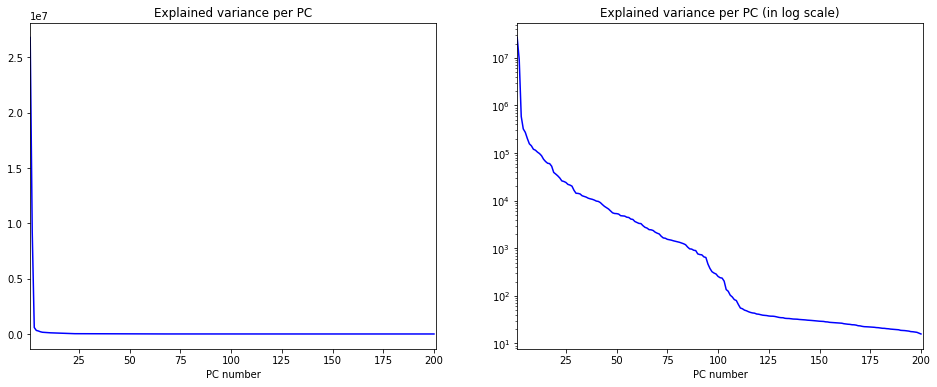

25 components are necessary to retain 99.00% of the total variance
Here are the first 10 components.


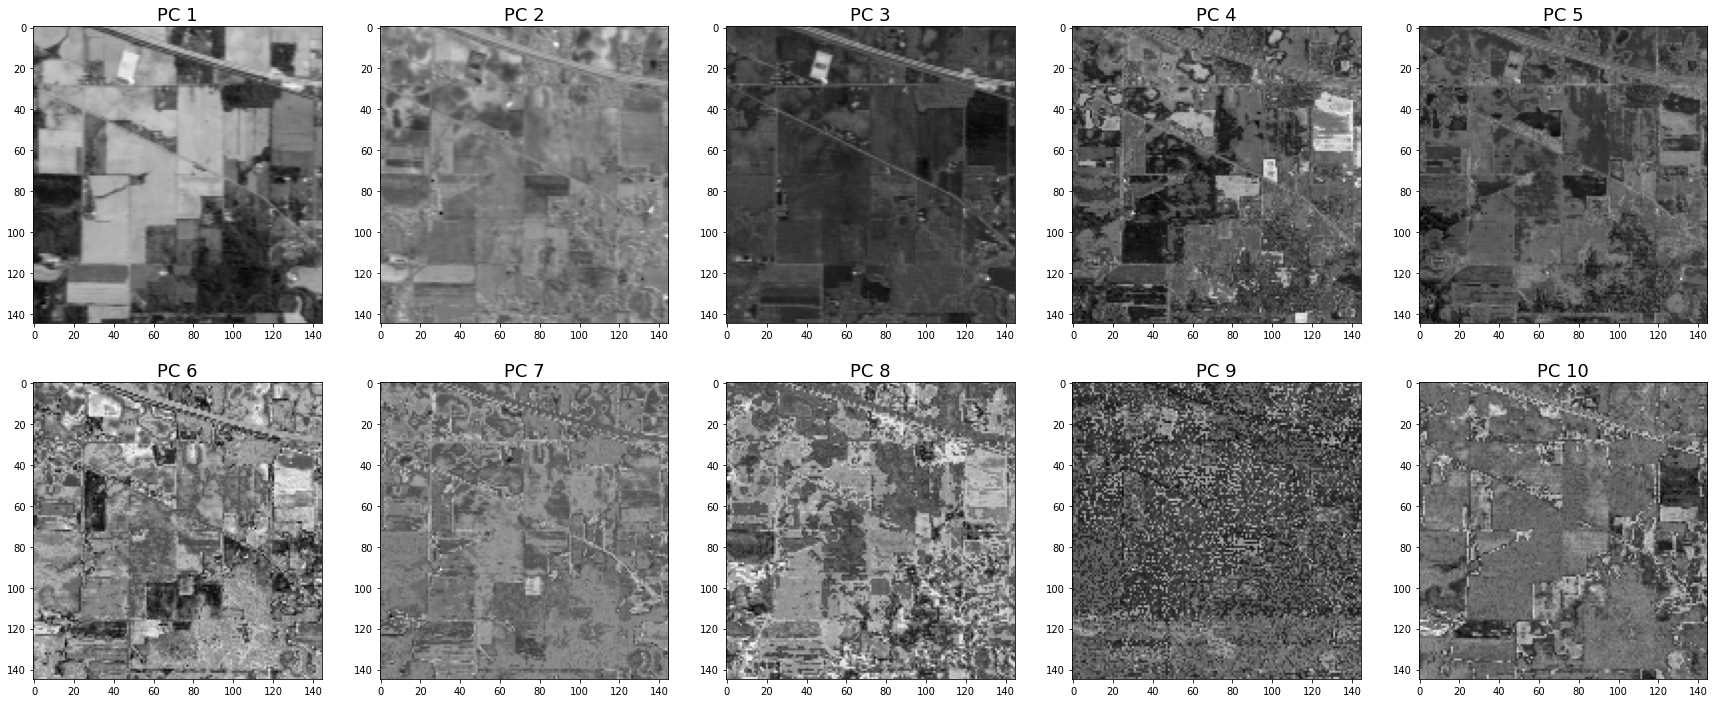

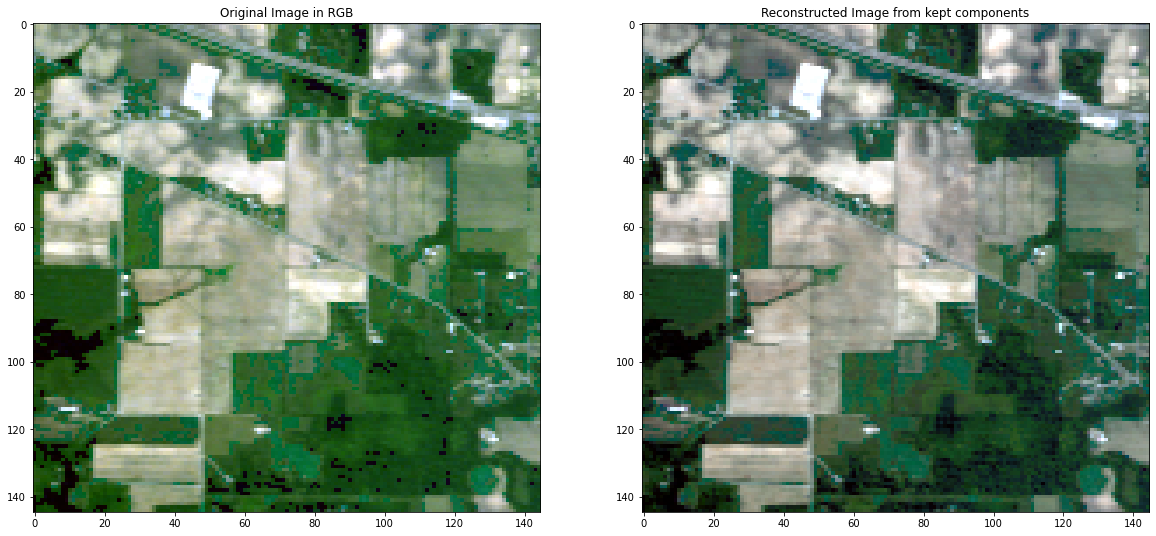

In [131]:
show_info_pca(arr_indiana, 0.99)

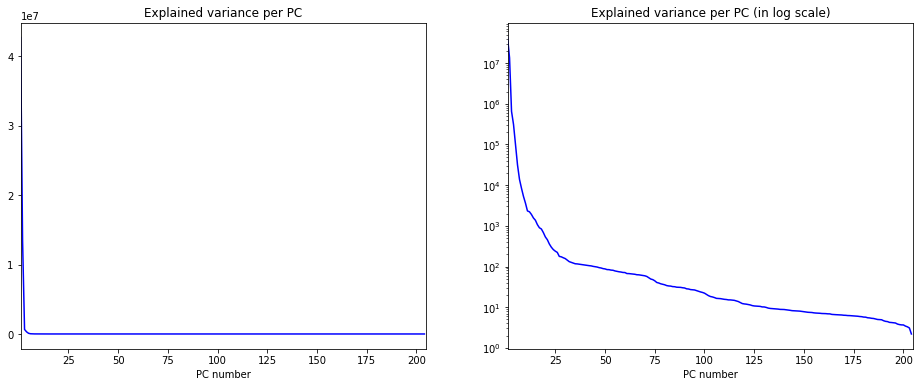

6 components are necessary to retain 99.90% of the total variance
Here are the first 5 components.


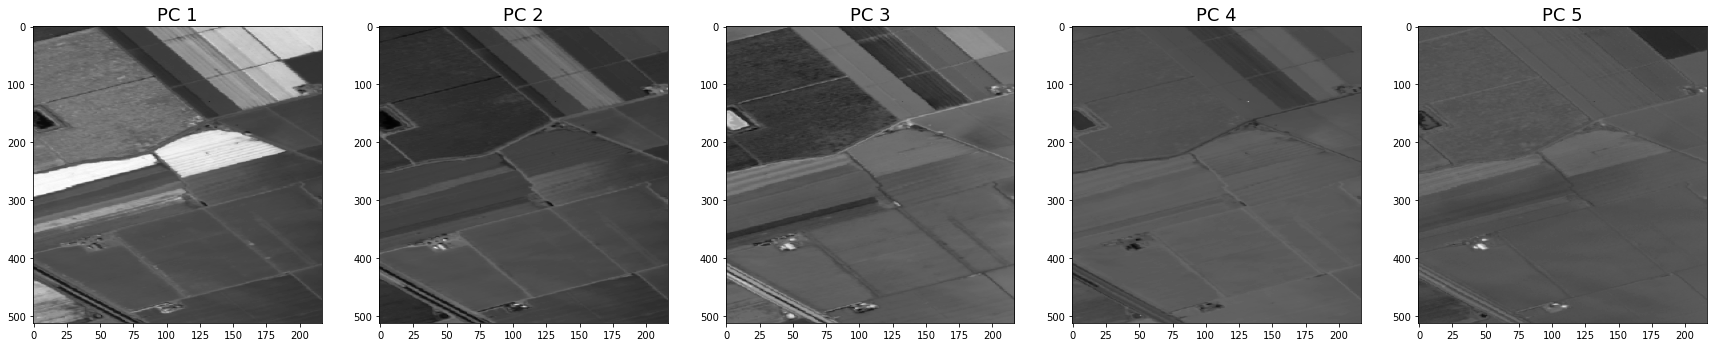

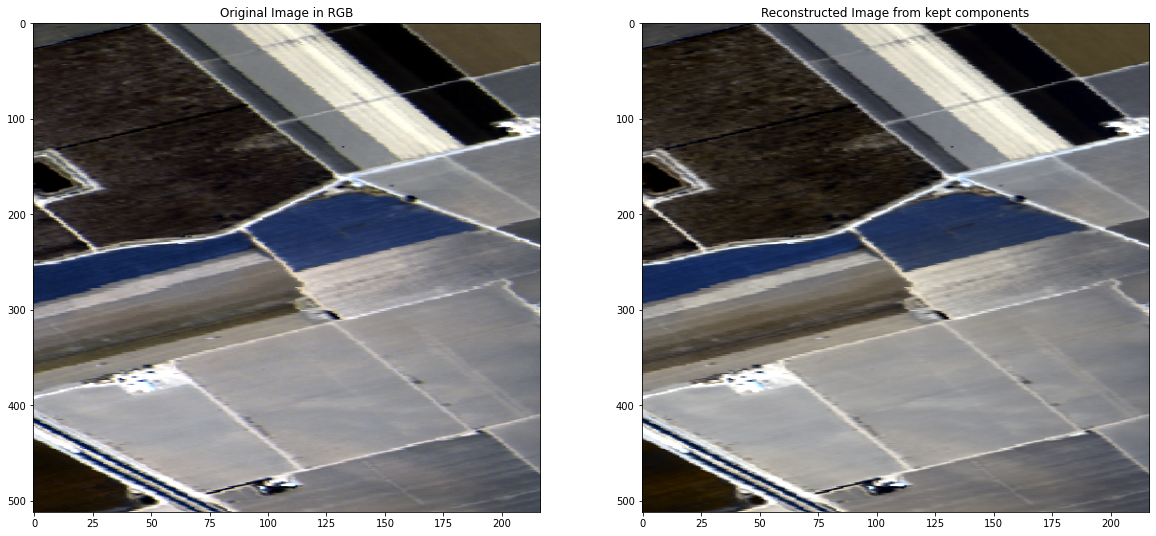

In [129]:
show_info_pca(arr_salinas, 0.999)

- On remarque que l'image Indiana pines demande de garder beaucoup plus de composantes pour avoir une variance de 99%, comparé à l'image Salinas qui atteind une variance expliquée de 99.9% avec seulement 5 composantes.\
Nous voyons donc bien qu'il sera critique que notre pipeline de traitement d'image puisse s'adapter à l'image d'entrée. Cela peut se traduire par l'ajout d'hyperparamètres qui seraient réglés pour chaque image d'entrée.
- Un autre point critique ici est le fait que nous avons effectué notre PCA sur l'entiereté du set de données. Seulement, en pratique nous auront seulement accès à une partie de l'image, le set d'entrainement.\
Il faudra donc que la décomposition apprise sur le set d'entrainement convient aussi au set de test. La partie suivante traite justement de la séparation en deux sets.


# Séparation en Train et Test set et approche de classification

Les deux images possédant des classes et une résolution différentes, apprendre les données d'une image pour ensuite classifier celles de l'autre n'a pas de sens.

Il va plutot convenir ici d'apprendre à classifier une partie de chaque image, qui sera le set d'entrainement, pour ensuite évaluer l'efficacité de la méthode sur le reste de l'image.

Cette approche à un avantage non négligeable : Travailler avec un dataset de train réduit, composé environ de 15% des pixels de l'image d'origine permettra lors de la classification de seulement labelliser 15% des images acquises, la pipeline de classification de chargeant d'induire le reste des labels.

Cela expose aussi l'approche *pixel-wise* que nous allons avoir. Chaque pixel sera en effet traité indépendemment de sa position sur l'image, en utilisant seulement les informations des bandes. Cela permet de créer des Test et Train set ayant la même répartition de classes, sans de voir découper des zones contigues dans l'image.

In [132]:
from sklearn.model_selection import train_test_split

def create_test_train(arr, arr_gt, test_size):
    arr = np.copy(arr)
    arr_gt = np.copy(arr_gt)
    
    # Encode in the last two band of each pixel the position of the pixel.
    # This is used for reforming the image from the test and train set a posteriori
    indices = []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            indices.append([i, j])
    indices = np.array(indices)
    
    dim = arr.shape[2]
    # flatten X and y
    X = arr.reshape((-1, dim))
    y = arr_gt.reshape((-1))
    # add the pixel positions into X
    X = np.column_stack([X, indices])
    
    # do the splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # retrieve the indices for each pixel
    
    train_indices = X_train[:,-2:]
    test_indices = X_test[:, -2:]
    
    # remove the indices from X_train and X_test
    
    X_train = X_train[:,:-2]
    X_test = X_test[:, :-2]
    
    return X_train, X_test, y_train, y_test, train_indices, test_indices

def rebuild_image(y_train, y_predicted, train_indices, test_indices, height, width):
    y_rebuilt = np.zeros((height, width))
    
    # set all the pixels predicted to their predicted value
    for i in range(len(y_predicted)):
        h, w = test_indices[i]
        y_rebuilt[h, w] = y_predicted[i]
    # set all the train pixels to their value
    for i in range(len(y_train)):
        h, w = train_indices[i]
        y_rebuilt[h, w] = y_train[i]
        
    return y_rebuilt

Par exemple, en mettant toutes les valeurs prédites à 0 :

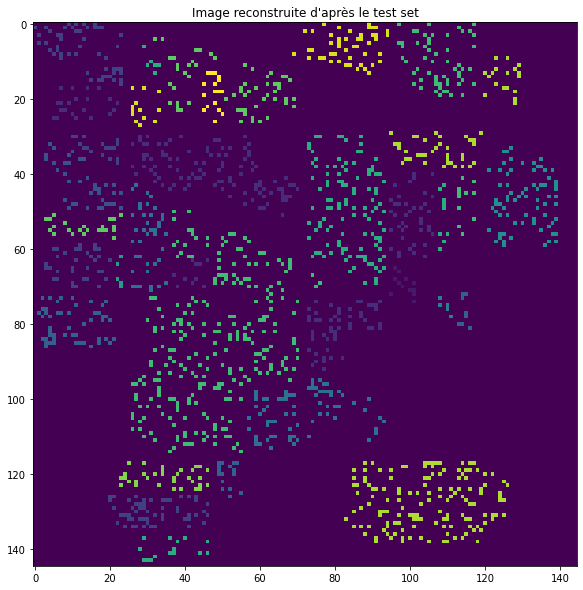

In [143]:
(X_train,
X_test,
y_train,
y_test,
train_indices,
test_indices) = create_test_train(arr_indiana, arr_indiana_gt, 0.85)

plt.figure(figsize=(10,10))
plt.imshow(rebuild_image(y_train, np.ones_like(y_test) * 0,
                         train_indices, test_indices,
                         arr_indiana.shape[0], arr_indiana.shape[1]))
plt.title("Image reconstruite d'après le test set")
plt.show()

Cette reconstruction sera aussi utile pour appliquer un post traitement.